## BERT (Bidirectional Encoder Representations from Transformers)
-



#### BERT NLP Application
- Google Search
- Sentiment Analysis
- Language Translation
- Text Summarization
- Question Answering
- Highlighting paragraphs

### Pre-trained bert model
- **BERT-base**: This is the base version of BERT with 12 transformer layers, 768 hidden units, and 12 self-attention heads.

- **BERT-large**: BERT-large is a larger version of BERT with 24 transformer layers, 1024 hidden units, and 16 self-attention heads

- **BERT-cased**: BERT-cased retains the casing information of the original text during pre-training. This can be useful for tasks where capitalization plays a significant role, such as named entity recognition.

- **BERT-uncased**: BERT-uncased converts all text to lowercase during pre-training. It is suitable when the case information is less important for the specific NLP task.





### Reference
http://jalammar.github.io/illustrated-bert/

## Sentiment analysis using BERT

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.6 MB/s eta 0:00:00


In [2]:
import transformers
from transformers import BertModel, BertTokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
if torch.cuda.is_available():
    torch.device('cuda')
else:
    torch.device('cpu')

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/ujjalkumarmaity/NLP/main/bert/reviews.csv',on_bad_lines='skip')
df = df[['content','score']]
def convert_sentiment(x):
    if x<=2:
        return 0
    elif x==3:
        return 1
    else:
        return 2
df['sentiment'] = df.score.apply(convert_sentiment)
df.head(5)

,content,score,sentiment
0,I cannot open the app anymore,1,0
1,I have been begging for a refund from this app...,1,0
2,Very costly for the premium version (approx In...,1,0
3,"Used to keep me organized, but all the 2020 UP...",1,0
4,Dan Birthday Oct 28,1,0


<Axes: >

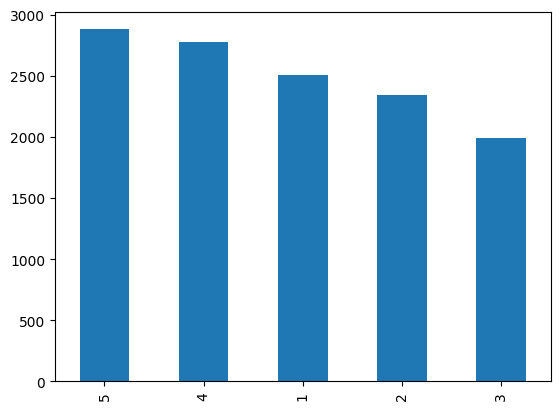

In [5]:
df.score.value_counts().plot(kind='bar')

In [6]:
df = df[['content','sentiment']]

In [16]:
# max word of content
df.content.str.split().str.len().max()

723

### Preprocess Data

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [8]:
# Construct a BERT tokenizer
tokenizer('let define the metrics you')

{'input_ids': [101, 1519, 9410, 1103, 12676, 1116, 1128, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
# Converts a string to a sequence of ids (integer), using the tokenizer and vocabulary.
tokenizer.encode('let define the metrics you')

[101, 1519, 9410, 1103, 12676, 1116, 1128, 102]

In [10]:
tokenizer.encode_plus("let define the metrics you")

{'input_ids': [101, 1519, 9410, 1103, 12676, 1116, 1128, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

### Prepare torch dataset

In [11]:
class ReviewData(Dataset):
    def __init__(self,tokenizer,review,label,max_len):
        self.tokenizer = tokenizer
        self.review = review
        self.label = label
        self.max_len = max_len

    def __len__(self):
        return len(self.review)
    def __getitem__(self,ind):
        review = self.review[ind]
        label = self.label[ind]
        embed = self.tokenizer.encode_plus(review,
                                           add_special_tokens=True,
                                           max_length = self.max_len,
                                           return_attention_mask = True,
                                           return_token_type_ids=False,
                                           pad_to_max_length = True,
                                           return_tensors = 'pt')
        return {
            'review' : review,
            'input_ids' : embed['input_ids'].flatten(),
            'attention_mask':embed['attention_mask'].flatten(),
            'label' : torch.tensor(label,dtype = torch.long)
        }

In [12]:
reviews = df.content.values
senttiment = df.sentiment.values
rd = ReviewData(tokenizer,reviews,senttiment,512)

In [13]:
print('review text',rd[5]['review'])
print('input_ids shape',rd[5]['input_ids'].shape)
print('attention_mask shape',rd[5]['attention_mask'].shape)
print(rd[5]['label'])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


review text It has changed how I viewed my different lists. Now they are all jumbled together and I can't find what I need.
input_ids shape torch.Size([512])
attention_mask shape torch.Size([512])
tensor(0)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


**Split Data**

In [14]:
train,test = train_test_split(df,test_size=0.3,random_state = 10)
test,val = train_test_split(test,test_size=0.4,random_state = 10)

**Create Pytorch DataLoader**

In [17]:
def cerate_dataloader(df,tokenizer,max_len,batch_size):
    reviews = df.content.values
    senttiment = df.sentiment.values
    rd = ReviewData(tokenizer,reviews,senttiment,max_len)
    return DataLoader(rd,batch_size = batch_size)


In [18]:
batch_size = 64
max_len = 512
train_dataloader = cerate_dataloader(train,tokenizer,max_len,batch_size)
val_dataloader = cerate_dataloader(val,tokenizer,max_len,batch_size)
test_dataloader = cerate_dataloader(test,tokenizer,max_len,batch_size)

### Model creation

In [25]:
bert = BertModel.from_pretrained('bert-base-cased')
bert.config

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [28]:
class SentimentModel(nn.Module):
    def __init__(self,n_class):
        super(SentimentModel,self).__init__()
        self.bert = BertModel.from_pretrained('bert_base_cased')
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(self.bert.config.hidden_size,n_class)

    def forward(self,input_ids,attention_mask):
        _,pooled_out = self.bert(input_ids = input_ids,attention_mask = attention_mask)
        out = self.dropout(pooled_out)
        return self.output(out)
